# Install necessary libs


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import random
import time
import shutil
import yaml
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Prepare Data

## Download data

In [ ]:
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=7e5564a9-22d7-4193-8d9a-5812b8c88b81
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:01<00:00, 43.8MB/s]


In [ ]:
!unzip icdar2003.zip

Archive:  icdar2003.zip
   creating: SceneTrialTrain/apanar_06.08.2002/
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1252.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1253.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1259.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1269.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1281.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1282.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1283.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1284.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1285.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1286.JPG 

##Extract from .xml files

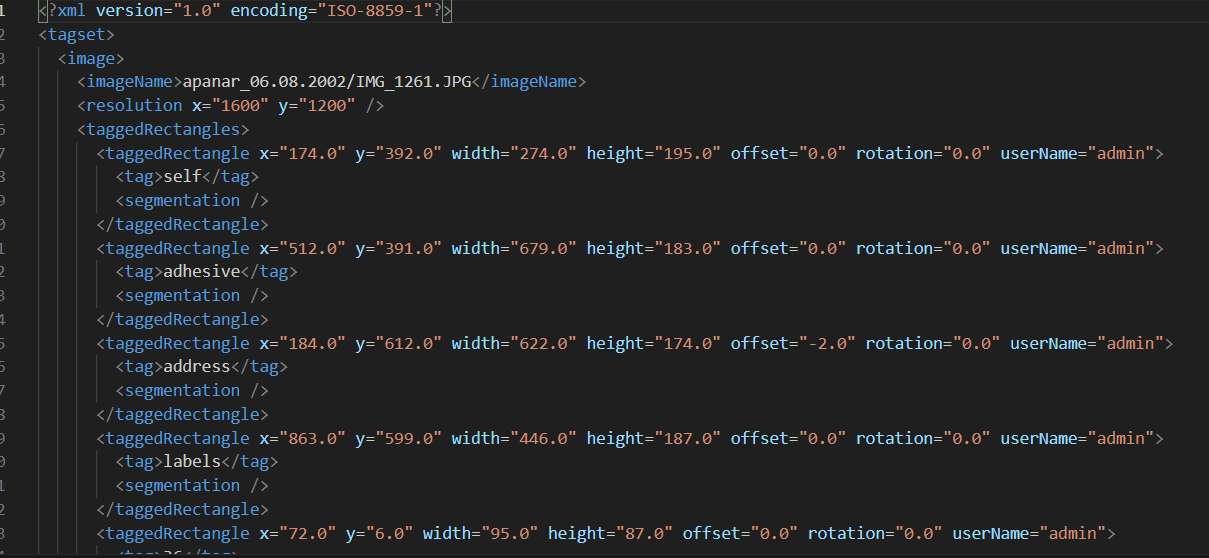

Structure of the file, including image path, bounding rect,...

In [ ]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [ ]:
dataset_dir = "SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(
    words_xml_path
)

##Convert data to YOLOv11 format

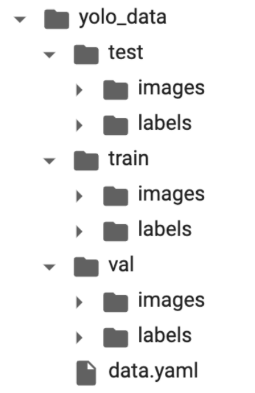

In this case, the label will be the coordinates of the bounding boxes

In [ ]:
def convert_to_yolo_format(img_paths, img_sizes, bboxes):
    yolo_data = []

    for img_path, img_size, bbox in zip(img_paths, img_sizes, bboxes):
        img_width, img_height = img_size

        yolo_labels = []

        for box in bbox:
            x, y, w, h = box

            # Calculate normalized bounding box coordinates
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            normalized_width = w / img_width
            normalized_height = h / img_height

            # Because we only have one class , we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label  = f"{class_id} {x_center} {y_center} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((img_path, yolo_labels))

    return yolo_data

In [ ]:
class_labels = ["text"]

yolo_data = convert_to_yolo_format(img_paths, img_sizes, bboxes)

## Split data to train, val, test

In [ ]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

##Save data to folder

In [ ]:
def save_data(data, src_img_dir, save_dir):
  # Create folder if not exists
  os.makedirs(save_dir, exist_ok = True)

  # Make images and labels folder
  os.makedirs(os.path.join(save_dir, "images"), exist_ok = True)
  os.makedirs(os.path.join(save_dir, "labels"), exist_ok = True)

  for img_path, yolo_labels in data:
      # Copy image to images folder
      shutil.copy(
          os.path.join(src_img_dir, img_path),
          os.path.join(save_dir, "images")
      )

      # Save labels to labels folder
      img_name = os.path.basename(img_path)
      img_name = os.path.splitext(img_name)[0]

      with open(os.path.join(save_dir, 'labels', f"{img_name}.txt"), "w") as f:
          for label in yolo_labels:
              f.write(f"{label}\n")

In [ ]:
save_yolo_data_dir = "./datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok = True)

save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(val_data, dataset_dir, save_val_dir)
save_data(test_data, dataset_dir, save_test_dir)

##Create yaml file

In [ ]:
data_yaml = {
    "path": 'yolo_data',
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels
}

yolo_yaml_path = os.path.join(save_yolo_data_dir , "data.yml")

with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style = False)

# Training

## Load a model

In [ ]:
from ultralytics import YOLO

#Load a model
model = YOLO('yolo11m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 143MB/s]


## Train the model

In [ ]:
!cat /content/datasets/yolo_data/data.yml


names:
- text
nc: 1
path: yolo_data
test: test/images
train: train/images
val: val/images


In [ ]:
results = model.train(
    data = yolo_yaml_path,
    epochs = 100,
    imgsz = 640,
    cache = True,
    patience = 20,
    plots = True
)

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=./datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 24.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 125MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1703.55it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 183.93it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/yolo_data/val/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 1136.76it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 7/7 [00:00<00:00, 40.65it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.02G      1.905      2.828      1.714         28        640: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          7         62      0.412      0.339      0.267      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.03G      1.248      1.365       1.19         81        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all          7         62       0.46       0.44      0.409       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.06G      1.218      1.252      1.214         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          7         62    0.00268     0.0806    0.00133   0.000445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.97G      1.402      1.322      1.336         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          7         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.09G      1.389      1.297      1.304         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all          7         62    0.00178     0.0484   0.000777   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.13G      1.393      1.355      1.272         47        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          7         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.01G      1.362      1.345      1.276         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all          7         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       8.1G      1.494      1.392      1.288         79        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all          7         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.12G      1.471      1.236      1.303         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all          7         62     0.0181     0.0323    0.00158   0.000423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.18G      1.427      1.243      1.265         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all          7         62      0.137       0.21     0.0797      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.15G      1.379      1.309      1.284         29        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all          7         62      0.206      0.258     0.0863     0.0296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.17G      1.406      1.199      1.257         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all          7         62      0.193      0.161     0.0707     0.0319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.09G       1.34      1.222      1.245         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all          7         62      0.428      0.323      0.331      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.09G      1.292      1.149      1.228         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all          7         62      0.456      0.435      0.372      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.11G      1.273      1.071      1.199         82        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all          7         62       0.32      0.371      0.257      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.12G      1.262      1.114      1.208         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all          7         62      0.175      0.613      0.229      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.07G      1.212      1.066      1.172         59        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all          7         62      0.279      0.435      0.224       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.04G      1.213      1.083      1.181         62        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all          7         62      0.461      0.323      0.319      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.15G      1.171      1.027      1.134         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all          7         62       0.64      0.419      0.438      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.14G      1.173     0.9919      1.138         76        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all          7         62      0.324      0.758      0.421      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.11G      1.149     0.9997      1.141         74        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all          7         62       0.62      0.419       0.46      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.15G      1.171      1.052      1.136         93        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all          7         62       0.53      0.435      0.447      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.15G      1.134      0.943      1.103         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all          7         62      0.518      0.565       0.56      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.12G      1.208     0.9848      1.154         52        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all          7         62      0.485        0.5      0.431      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.02G      1.093      0.901      1.104         65        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all          7         62      0.591      0.443      0.453      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.17G      1.098     0.9007      1.101         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all          7         62      0.585      0.403      0.433      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.09G       1.09     0.9185       1.13         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          7         62      0.591      0.419      0.441      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.13G      1.076     0.8971      1.086         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all          7         62      0.588        0.5      0.541      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.11G      1.057     0.9346      1.101         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all          7         62      0.398      0.742      0.554      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.13G      1.052     0.8754      1.089         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all          7         62      0.632      0.516      0.575      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.17G      1.071     0.8736       1.11         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all          7         62      0.576      0.613      0.622       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.12G      1.059     0.8646      1.087         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all          7         62       0.58      0.532      0.569       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       8.1G      1.048     0.8134      1.073         63        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all          7         62      0.657      0.597      0.647      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.14G      1.101     0.8769      1.112         87        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          7         62      0.538      0.621      0.591      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.13G      1.036     0.8217      1.083         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all          7         62      0.532      0.532       0.54      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.14G      1.067     0.8143      1.087         35        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all          7         62      0.649      0.565       0.61      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.97G      1.014     0.8342      1.074         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          7         62      0.503      0.669      0.597      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.09G     0.9914     0.7778       1.05         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          7         62       0.64      0.597      0.648      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.14G     0.9788      0.799      1.061         37        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all          7         62      0.641      0.645      0.645      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.15G     0.9772     0.7841      1.064         73        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all          7         62      0.532      0.605      0.546      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.12G     0.9582     0.7681      1.045         46        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all          7         62       0.65      0.599      0.614      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.15G     0.9744     0.7547      1.046         66        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          7         62      0.584      0.677       0.65      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.13G     0.9674     0.7741      1.044         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all          7         62      0.558       0.71      0.673       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.14G     0.9394     0.7441      1.036         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


                   all          7         62      0.697      0.645      0.702      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.97G     0.9245     0.7275      1.018         41        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all          7         62      0.725      0.637      0.677        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       8.1G     0.9697     0.7584      1.076         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          7         62      0.504      0.839      0.634      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.12G     0.9274     0.7336      1.043         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all          7         62      0.632      0.677      0.694      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.11G     0.8863     0.6806      1.027        102        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all          7         62      0.646      0.648      0.723      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.11G     0.9161     0.7035      1.027         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all          7         62      0.746      0.616      0.706      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       8.1G     0.9572     0.7254       1.03         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all          7         62      0.712      0.613      0.659      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.09G      0.903     0.7051      1.012         33        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all          7         62      0.698      0.629      0.695      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.03G     0.8916     0.6863      1.032         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all          7         62      0.846      0.706      0.801      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.09G     0.8795     0.6651      1.015         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          7         62      0.712      0.661      0.694      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.13G     0.8972     0.6725      1.027         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all          7         62      0.744      0.597      0.666      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.13G     0.8908     0.6893      1.012         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all          7         62      0.816      0.613      0.738      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.17G     0.8824     0.6859     0.9998         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all          7         62      0.691      0.758      0.768      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.09G     0.9191     0.6771       1.01         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all          7         62      0.637      0.806      0.746      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.08G      0.859     0.6715      1.012         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all          7         62      0.654      0.726      0.728      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.13G     0.8196     0.6317     0.9814         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all          7         62      0.648       0.83      0.766      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.09G      0.785     0.5806     0.9682         47        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all          7         62      0.733       0.71      0.742      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.08G      0.818     0.6045     0.9826         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all          7         62      0.651      0.784      0.769      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       8.1G     0.8516     0.6457      1.004         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all          7         62      0.789      0.665      0.771      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       8.1G     0.8084     0.6329     0.9845         64        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all          7         62      0.672      0.762      0.718      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.04G     0.8118     0.5982     0.9729         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all          7         62       0.65       0.71      0.703      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       8.1G     0.8286     0.6272     0.9885         41        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all          7         62      0.697      0.742      0.736      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.07G     0.8031     0.5899     0.9755         80        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all          7         62      0.714      0.764      0.731      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.14G     0.8185     0.6099     0.9815         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          7         62      0.764       0.73      0.735       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.04G     0.8388     0.6165     0.9924         75        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


                   all          7         62      0.692       0.71      0.747      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.02G     0.7796     0.5852     0.9759         42        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all          7         62      0.697      0.629      0.648      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.17G     0.8093     0.6196     0.9806         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all          7         62      0.663      0.666      0.697      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.14G      0.825     0.6191     0.9961         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all          7         62      0.674      0.702      0.711      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.14G     0.8246     0.6328     0.9927         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all          7         62      0.747      0.548      0.662       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.05G     0.7867     0.6083     0.9773         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all          7         62      0.691      0.694      0.748      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.03G     0.8001     0.6115     0.9986         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all          7         62      0.628      0.682      0.699      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.09G       0.76     0.5478     0.9692         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all          7         62      0.669      0.694      0.727      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.09G     0.7681     0.5692     0.9656         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all          7         62      0.793       0.62      0.751      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.11G     0.7625      0.565     0.9652         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all          7         62      0.774      0.677      0.747      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.08G     0.7414     0.5364     0.9588         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          7         62      0.808      0.661      0.761      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.03G     0.7488     0.5289     0.9425         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all          7         62      0.744       0.75      0.805      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.15G     0.6903     0.5035     0.9388         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all          7         62      0.706      0.815      0.798      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.03G     0.7149     0.5276     0.9508         45        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all          7         62      0.746      0.774      0.823       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       8.1G     0.7634     0.5436     0.9534         94        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all          7         62      0.694       0.77      0.793      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.12G     0.7386     0.5345     0.9611         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all          7         62      0.711      0.774      0.781       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.11G     0.7486     0.5265      0.954         58        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all          7         62      0.749      0.772      0.797      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.12G     0.7245     0.5231     0.9625         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all          7         62      0.774      0.806      0.809      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.13G     0.7062     0.5182     0.9431         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all          7         62      0.786       0.83      0.832      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.13G      0.729      0.529     0.9558         45        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all          7         62      0.787      0.774      0.803      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.12G      0.695     0.5113     0.9476         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all          7         62      0.805       0.71      0.776      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.98G     0.7061     0.4985     0.9241         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all          7         62      0.813      0.699      0.782      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.13G     0.6818     0.4926     0.9292         70        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all          7         62       0.82      0.758      0.826      0.527


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.12G      0.741     0.5671     0.9488         47        640: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all          7         62      0.806      0.726      0.788      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.08G      0.749     0.5822     0.9475         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all          7         62      0.842      0.774      0.803      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.02G     0.7481     0.5605     0.9529         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all          7         62      0.793      0.758      0.792      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.1G     0.7103     0.5456     0.9421         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all          7         62      0.775      0.777      0.803      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.17G     0.7281     0.5318       0.94         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all          7         62      0.766       0.79      0.801      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.15G     0.7038      0.545     0.9406         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all          7         62      0.793      0.742      0.792      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.07G     0.6856     0.5009      0.916         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all          7         62      0.811      0.726      0.802      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.18G     0.7252     0.5583     0.9428         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all          7         62      0.819      0.742      0.817      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.12G     0.6951     0.5187     0.9301         18        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all          7         62       0.78      0.774      0.816      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.17G     0.6696     0.4894     0.9101         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          7         62      0.785      0.742      0.804      0.523



100 epochs completed in 0.238 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


                   all          7         62      0.786       0.83      0.833      0.555
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## Evaluation

In [ ]:
model_path = "runs/detect/train/weights/best.pt"

model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


                   all          7         62      0.786       0.83      0.833      0.552
Speed: 0.3ms preprocess, 34.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val2


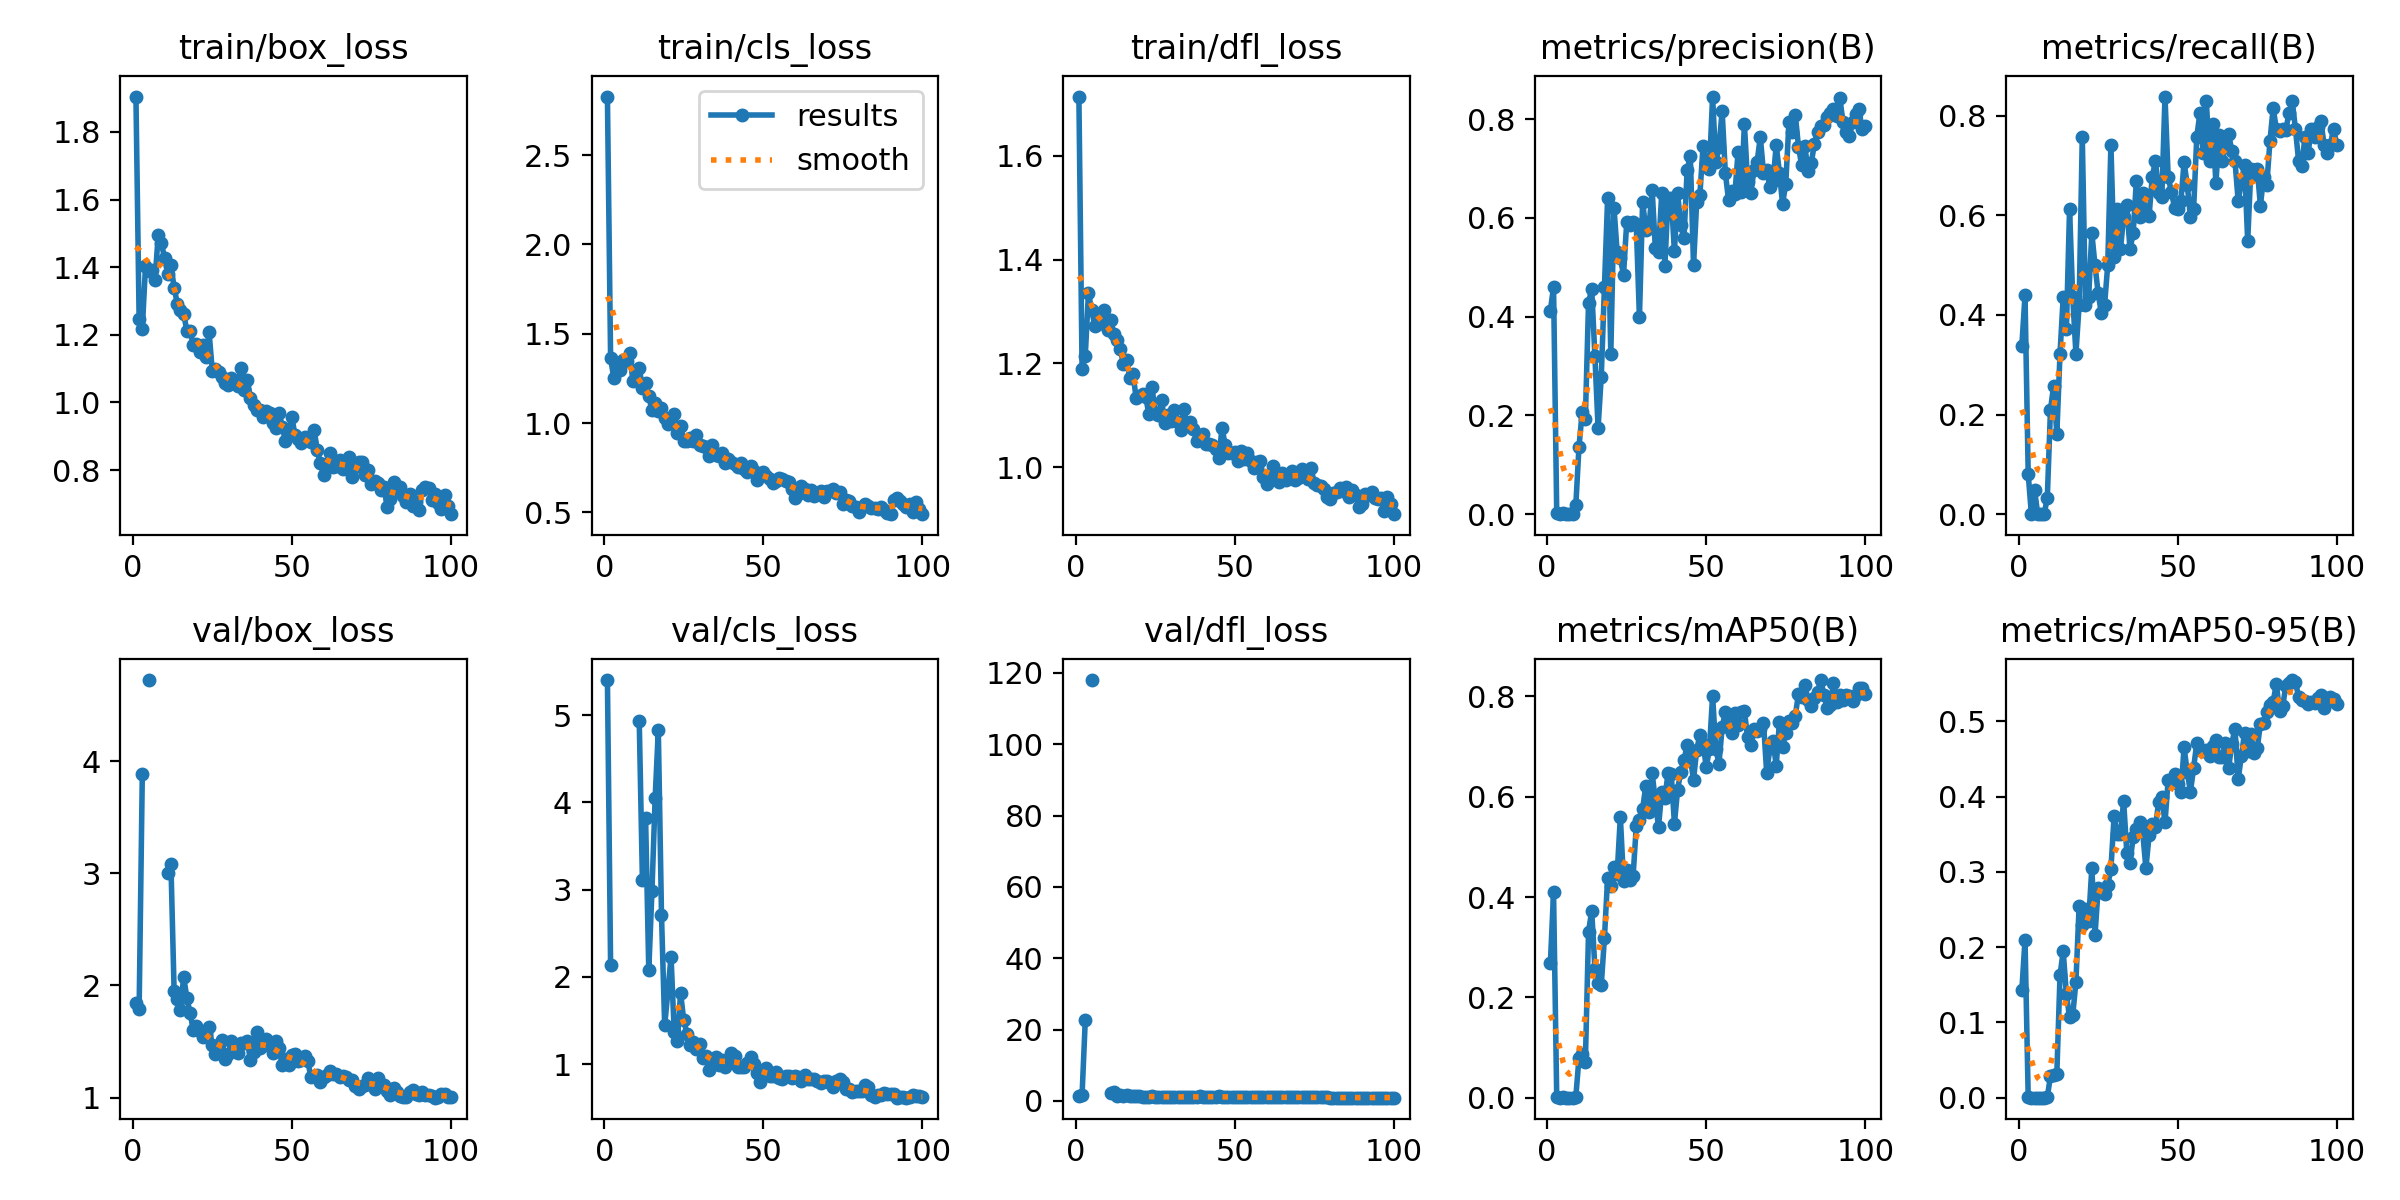

In [ ]:
results_path = 'runs/detect/train/results.png'

image = Image.open(results_path)
image

# Download best model

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/train_batch1170.jpg (deflated 10%)
  adding: content/runs/detect/train/results.png (deflated 7%)
  adding: content/runs/detect/train/R_curve.png (deflated 16%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 42%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 41%)
  adding: content/runs/detect/train/labels.jpg (deflated 30%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/best.pt (deflated 8%)
  adding: content/runs/detect/train/weights/last.pt (deflated 8%)
  adding: content/runs/detect/train/F1_curve.png (deflated 16%)
  adding: content/runs/detect/train/P_curve.png (deflated 18%)
  adding: content/runs/detect/train/train_batch1172.jpg (deflated 12%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 39%

In [ ]:
from google.colab import files

files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>